# Notebook 01 – Data Preprocessing

**Pipeline stages covered:**
0. Standardize column names and clean raw datasets (CIC-DDoS2019 + CIC-IDS2018)
1. Load cleaned datasets
2. Exploratory visualization (class distribution, null values)
3. Remove duplicates, NaN / Inf values
4. One-hot encode labels
5. Visualize cleaned data
6. Persist cleaned dataset for Notebook 02

> **Data leakage note:** Scaling and encoding are intentionally deferred to
> Notebook 02, *after* the train/test split.

## 0 · Standardize & Clean Raw Datasets

This section standardizes the column naming of every raw CSV to the **cicflowmeter_library** schema, then:
- **CIC-DDoS2019** – removes all `Benign` rows (keep only attack traffic)
- **CIC-IDS2018** – keeps only `Benign` rows (discard attack traffic)
- Removes NaN / Inf values
- Removes duplicate rows
- Randomly shrinks each file to at most **150 000 rows**
- Saves each processed file as a `.pkl` file in the same directory as the source CSV

> **Run this section only once** (or whenever the source CSVs change). Subsequent runs will overwrite the `.pkl` files.

In [1]:
# ── Section 0: Configuration ─────────────────────────────────────────────────
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
from utils.standardize_datasets import DataStandardizer

CONFIG_FILE  = '../utils/all_column_names.json'
DDOS_DIR     = '../data/CIC-DDoS2019'
IDS_DIR      = '../data/CIC-IDS2018'
MAX_ROWS     = 150_000
RANDOM_STATE = 42

print(f'Config  : {os.path.abspath(CONFIG_FILE)}')
print(f'DDoS dir: {os.path.abspath(DDOS_DIR)}')
print(f'IDS dir : {os.path.abspath(IDS_DIR)}')
print(f'Max rows per file: {MAX_ROWS:,}')

Config  : e:\Documents\Programming\Python\project\AI\Transformer DDoS Detector\utils\all_column_names.json
DDoS dir: e:\Documents\Programming\Python\project\AI\Transformer DDoS Detector\data\CIC-DDoS2019
IDS dir : e:\Documents\Programming\Python\project\AI\Transformer DDoS Detector\data\CIC-IDS2018
Max rows per file: 150,000


### 0.1 · CIC-DDoS2019  — Drop Benign rows, keep attack traffic

In [2]:
# ── Process CIC-DDoS2019 ─────────────────────────────────────────────────────
ddos_std = DataStandardizer(CONFIG_FILE, DDOS_DIR, DDOS_DIR)
ddos_results = ddos_std.run(
    drop_label=['Benign', 'WebDDoS'],
    max_rows=MAX_ROWS,
    random_state=RANDOM_STATE,
)
print(f'\nDone. Processed {len(ddos_results)} file(s).')

Found 11 CSV file(s) in '../data/CIC-DDoS2019'.
Processing: DrDoS_LDAP.csv...
  Dropped label(s) ['Benign', 'WebDDoS']: 1,612 rows removed
  Removed NaN/Inf: 38,630 rows removed
  Removed duplicates: 7 rows removed
  Randomly sampled to 150,000 rows
  Saved to: ../data/CIC-DDoS2019\DrDoS_LDAP.pkl  (150,000 rows × 76 cols)

Processing: DrDoS_MSSQL.csv...
  Dropped label(s) ['Benign', 'WebDDoS']: 2,006 rows removed
  Removed NaN/Inf: 126,446 rows removed
  Removed duplicates: 9 rows removed
  Randomly sampled to 150,000 rows
  Saved to: ../data/CIC-DDoS2019\DrDoS_MSSQL.pkl  (150,000 rows × 76 cols)

Processing: DrDoS_NetBIOS.csv...
  Dropped label(s) ['Benign', 'WebDDoS']: 1,707 rows removed
  Removed NaN/Inf: 129,833 rows removed
  Removed duplicates: 2 rows removed
  Randomly sampled to 150,000 rows
  Saved to: ../data/CIC-DDoS2019\DrDoS_NetBIOS.pkl  (150,000 rows × 76 cols)

Processing: DrDoS_NTP.csv...
  Dropped label(s) ['Benign', 'WebDDoS']: 14,365 rows removed
  Removed NaN/Inf: 6

In [3]:
# ── Display CIC-DDoS2019 results ─────────────────────────────────────────────
rows = []
for r in ddos_results:
    if 'Error' in r:
        rows.append({'File': r['File'], 'Status': f"ERROR: {r['Error']}"})
    else:
        rows.append({
            'File'                  : r['File'],
            'Detected Schema'       : r['Detected Type'],
            'Orig Rows'             : f"{r['Original Rows']:,}",
            'After Label Filter'    : f"{r['Rows After Label Filter']:,}",
            'After NaN/Inf Removal' : f"{r['Rows After NaN/Inf Removal']:,}",
            'After Dedup'           : f"{r['Rows After Dedup']:,}",
            'Final Rows'            : f"{r['Final Rows']:,}",
            'Orig Cols'             : r['Original Column Count'],
            'Final Cols'            : r['Final Column Count'],
            'Missing Cols'          : len(r['Missing Columns (Target cols not found)']),
            'Dropped Cols'          : len(r['Dropped Columns (Extras/Duplicates)']),
        })

df_ddos_summary = pd.DataFrame(rows)
display(df_ddos_summary)

# Show missing / dropped details for each file
for r in ddos_results:
    if 'Error' not in r:
        missing = r['Missing Columns (Target cols not found)']
        dropped = r['Dropped Columns (Extras/Duplicates)']
        if missing:
            print(f"\n{r['File']} — Missing columns ({len(missing)}): {missing}")
        if dropped:
            print(f"{r['File']} — Dropped columns ({len(dropped)}): {dropped}")

,File,Detected Schema,Orig Rows,After Label Filter,After NaN/Inf Removal,After Dedup,Final Rows,Orig Cols,Final Cols,Missing Cols,Dropped Cols
0,DrDoS_LDAP.csv,cic_ids2018_naming,"2,181,542","2,179,930","2,141,300","2,141,293","150,000",88,76,7,12
1,DrDoS_MSSQL.csv,cic_ids2018_naming,"4,524,498","4,522,492","4,396,046","4,396,037","150,000",88,76,7,12
2,DrDoS_NetBIOS.csv,cic_ids2018_naming,"4,094,986","4,093,279","3,963,446","3,963,444","150,000",88,76,7,12
3,DrDoS_NTP.csv,cic_ids2018_naming,"1,217,007","1,202,642","1,195,690","1,195,676","150,000",88,76,7,12
4,DrDoS_SNMP.csv,cic_ids2018_naming,"5,161,377","5,159,870","5,149,261","5,149,234","150,000",88,76,7,12
5,DrDoS_SSDP.csv,cic_ids2018_naming,"2,611,374","2,610,611","2,568,569","2,568,561","150,000",88,76,7,12
6,DrDoS_UDP.csv,cic_ids2018_naming,"3,136,802","3,134,645","3,094,002","3,093,991","150,000",88,76,7,12
7,Portmap.csv,cic_ids2018_naming,"191,694","186,960","177,197","177,197","150,000",88,76,7,12
8,Syn.csv,cic_ids2018_naming,"1,582,681","1,582,289","1,379,983","1,379,982","150,000",88,76,7,12
9,TFTP_Shrunk.csv,cic_ids2018_naming,"4,000,000","3,997,905","3,943,974","3,943,961","150,000",88,76,7,12



DrDoS_LDAP.csv — Missing columns (7): ['bwd_seg_size_avg', 'cwr_flag_count', 'fwd_seg_size_avg', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts']
DrDoS_LDAP.csv — Dropped columns (12): ['CWE Flag Count', 'Flow ID', 'Fwd Header Length.1', 'Inbound', 'SimillarHTTP', 'Unnamed: 0', 'bwd_seg_size_avg', 'fwd_seg_size_avg', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts']

DrDoS_MSSQL.csv — Missing columns (7): ['bwd_seg_size_avg', 'cwr_flag_count', 'fwd_seg_size_avg', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts']
DrDoS_MSSQL.csv — Dropped columns (12): ['CWE Flag Count', 'Flow ID', 'Fwd Header Length.1', 'Inbound', 'SimillarHTTP', 'Unnamed: 0', 'bwd_seg_size_avg', 'fwd_seg_size_avg', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts']

DrDoS_NetBIOS.csv — Missing columns (7): ['bwd_seg_size_avg', 'cwr_flag_count', 'fwd_seg_size_avg', 'subflow_bwd_byts', 'subflow_bwd_pk

### 0.2 · CIC-IDS2018  — Keep only Benign rows

In [4]:
# ── Process CIC-IDS2018 ──────────────────────────────────────────────────────
ids_std = DataStandardizer(CONFIG_FILE, IDS_DIR, IDS_DIR)
ids_results = ids_std.run(
    keep_label='Benign',
    max_rows=MAX_ROWS,
    random_state=RANDOM_STATE,
)
print(f'\nDone. Processed {len(ids_results)} file(s).')

Found 1 CSV file(s) in '../data/CIC-IDS2018'.
Processing: Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv...
  Kept only label='Benign': 576,191 rows removed
  Removed NaN/Inf: 59,453 rows removed
  Removed duplicates: 1 rows removed
  Randomly sampled to 150,000 rows
  Saved to: ../data/CIC-IDS2018\Thuesday-20-02-2018_TrafficForML_CICFlowMeter.pkl  (150,000 rows × 76 cols)


Done. Processed 1 file(s).


In [5]:
# ── Display CIC-IDS2018 results ──────────────────────────────────────────────
rows = []
for r in ids_results:
    if 'Error' in r:
        rows.append({'File': r['File'], 'Status': f"ERROR: {r['Error']}"})
    else:
        rows.append({
            'File'                  : r['File'],
            'Detected Schema'       : r['Detected Type'],
            'Orig Rows'             : f"{r['Original Rows']:,}",
            'After Label Filter'    : f"{r['Rows After Label Filter']:,}",
            'After NaN/Inf Removal' : f"{r['Rows After NaN/Inf Removal']:,}",
            'After Dedup'           : f"{r['Rows After Dedup']:,}",
            'Final Rows'            : f"{r['Final Rows']:,}",
            'Orig Cols'             : r['Original Column Count'],
            'Final Cols'            : r['Final Column Count'],
            'Missing Cols'          : len(r['Missing Columns (Target cols not found)']),
            'Dropped Cols'          : len(r['Dropped Columns (Extras/Duplicates)']),
        })

df_ids_summary = pd.DataFrame(rows)
display(df_ids_summary)

# Show missing / dropped details for each file
for r in ids_results:
    if 'Error' not in r:
        missing = r['Missing Columns (Target cols not found)']
        dropped = r['Dropped Columns (Extras/Duplicates)']
        if missing:
            print(f"\n{r['File']} — Missing columns ({len(missing)}): {missing}")
        if dropped:
            print(f"{r['File']} — Dropped columns ({len(dropped)}): {dropped}")

,File,Detected Schema,Orig Rows,After Label Filter,After NaN/Inf Removal,After Dedup,Final Rows,Orig Cols,Final Cols,Missing Cols,Dropped Cols
0,Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv,cic_ids2018_naming,"7,948,748","7,372,557","7,313,104","7,313,103","150,000",84,76,7,8



Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv — Missing columns (7): ['bwd_seg_size_avg', 'cwr_flag_count', 'fwd_seg_size_avg', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts']
Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv — Dropped columns (8): ['CWE Flag Count', 'Flow ID', 'bwd_seg_size_avg', 'fwd_seg_size_avg', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts']


In [6]:
# ── Imports ────────────────────────────────────────────────────────────────
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from utils.data_loader   import load_all_datasets
from utils.preprocessing import (
    remove_duplicates_and_nulls,
    split_features_labels,
    fit_label_encoder,
    encode_labels,
    get_label_mapping,
)
from utils.visualization import (
    plot_label_distribution,
    plot_missing_values,
)

print('✓ Imports OK')

✓ Imports OK


In [7]:
# ── Configuration ──────────────────────────────────────────────────────────
DDOS2019_DIR  = '../data/CIC-DDoS2019'
ids2018_dir   = '../data/CIC-IDS2018'
OUTPUT_DIR    = '../data/processed'
LABEL_COL     = 'Label'

# Set SAMPLE_FRAC < 1.0 for quick development runs; use None for full data
SAMPLE_FRAC   = None   # e.g. 0.05 for 5 % of each file
RANDOM_STATE  = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f'Output directory: {os.path.abspath(OUTPUT_DIR)}')

Output directory: e:\Documents\Programming\Python\project\AI\Transformer DDoS Detector\data\processed


## 1 · Load Datasets

In [8]:
df_raw = load_all_datasets(
    ddos2019_dir=DDOS2019_DIR,
    ids2018_dir=ids2018_dir,
    sample_frac=SAMPLE_FRAC,
    random_state=RANDOM_STATE,
)
print(f'\nRaw dataset shape: {df_raw.shape}')
df_raw.head(3)

Loading CIC-DDoS2019: 100%|██████████| 11/11 [00:00<00:00, 11.49it/s]


[data_loader] Dropping metadata columns: ['src_ip', 'dst_ip', 'timestamp']
[data_loader] Loaded 11 file(s) from 'CIC-DDoS2019' → 1,650,000 rows × 73 cols
[data_loader] Class distribution:
Label
DrDoS_LDAP       150000
DrDoS_MSSQL      150000
DrDoS_NTP        150000
DrDoS_NetBIOS    150000
DrDoS_SNMP       150000
DrDoS_SSDP       150000
DrDoS_UDP        150000
Portmap          150000
Syn              150000
TFTP             150000
UDP-lag          150000



Loading CIC-IDS2018: 100%|██████████| 1/1 [00:00<00:00, 22.74it/s]

[data_loader] Dropping metadata columns: ['src_ip', 'dst_ip', 'timestamp']
[data_loader] Loaded 1 file(s) from 'CIC-IDS2018' → 150,000 rows × 73 cols
[data_loader] Class distribution:
Label
Benign    150000




[data_loader] Combined dataset: 1,800,000 rows × 73 cols
[data_loader] Overall class distribution:
Label
DrDoS_LDAP       150000
DrDoS_MSSQL      150000
DrDoS_NTP        150000
DrDoS_NetBIOS    150000
DrDoS_SNMP       150000
DrDoS_SSDP       150000
DrDoS_UDP        150000
Portmap          150000
Syn              150000
TFTP             150000
UDP-lag          150000
Benign           150000


Raw dataset shape: (1800000, 73)


,src_port,dst_port,protocol,flow_duration,flow_byts_s,flow_pkts_s,fwd_pkts_s,bwd_pkts_s,tot_fwd_pkts,tot_bwd_pkts,...,idle_min,idle_mean,idle_std,fwd_byts_b_avg,fwd_pkts_b_avg,bwd_byts_b_avg,bwd_pkts_b_avg,fwd_blk_rate_avg,bwd_blk_rate_avg,Label
0,646,5902,17,2,1.472000e+09,1000000.0,1000000.0,0.0,2,0,...,0.0,0.0,0.0,0,0,0,0,0,0,DrDoS_LDAP
1,730,34483,17,2,1.464000e+09,1000000.0,1000000.0,0.0,2,0,...,0.0,0.0,0.0,0,0,0,0,0,0,DrDoS_LDAP
2,900,17522,17,1,2.704000e+09,2000000.0,2000000.0,0.0,2,0,...,0.0,0.0,0.0,0,0,0,0,0,0,DrDoS_LDAP


## 2 · Exploratory Analysis — Raw Data

In [9]:
# Data types and memory
print('=== Dataset Info ===')
print(f'Rows: {df_raw.shape[0]:,}  |  Columns: {df_raw.shape[1]}')
print(f'Memory usage: {df_raw.memory_usage(deep=True).sum() / 1e6:.1f} MB')
display(df_raw.dtypes.value_counts().rename('dtype count'))

=== Dataset Info ===
Rows: 1,800,000  |  Columns: 73
Memory usage: 1066.1 MB


float64    43
int64      29
str         1
Name: dtype count, dtype: int64

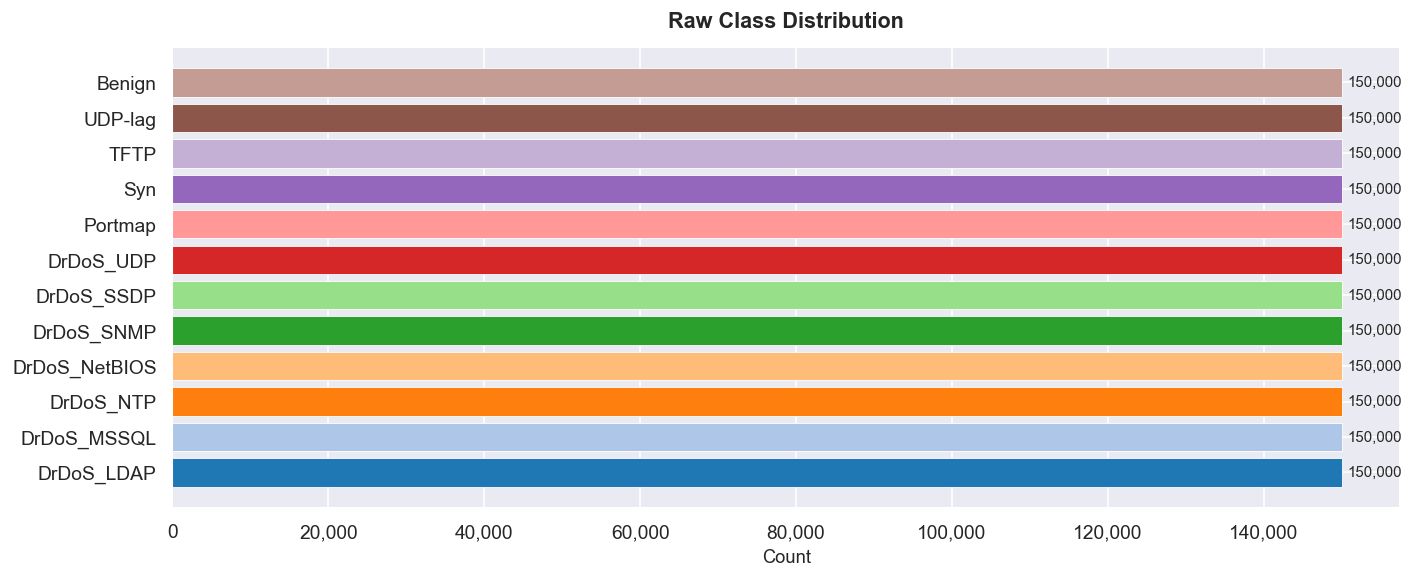

In [10]:
# ── Raw class distribution ─────────────────────────────────────────────────
fig = plot_label_distribution(df_raw[LABEL_COL], title='Raw Class Distribution')
fig.savefig(f'{OUTPUT_DIR}/fig_01_raw_class_dist.png', dpi=120, bbox_inches='tight')
plt.show()

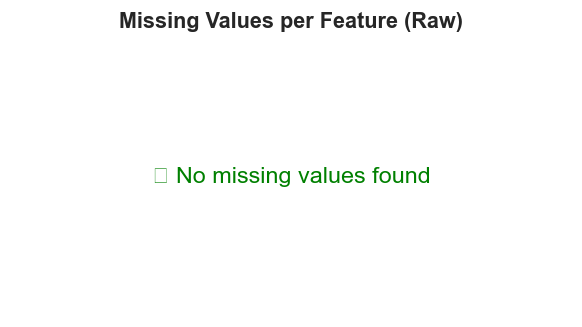

Total NaN: 0  |  Total Inf: 0  |  Duplicates: 971


In [11]:
# ── Missing / null values ──────────────────────────────────────────────────
fig = plot_missing_values(df_raw, title='Missing Values per Feature (Raw)')
fig.savefig(f'{OUTPUT_DIR}/fig_02_missing_values.png', dpi=120, bbox_inches='tight')
plt.show()

total_null = df_raw.isnull().sum().sum()
total_inf  = np.isinf(df_raw.select_dtypes('number')).sum().sum()
total_dup  = df_raw.duplicated().sum()
print(f'Total NaN: {total_null:,}  |  Total Inf: {total_inf:,}  |  Duplicates: {total_dup:,}')

## 3 · Cleaning — Remove Duplicates, NaN, and Inf

In [12]:
df_clean = remove_duplicates_and_nulls(df_raw, verbose=True)
print(f'\nCleaned dataset shape: {df_clean.shape}')

[preprocessing] Original rows :  1,800,000
[preprocessing] Removed duplicates :        971
[preprocessing] Removed NaN/Inf :          0
[preprocessing] Remaining rows :  1,799,029

Cleaned dataset shape: (1799029, 73)


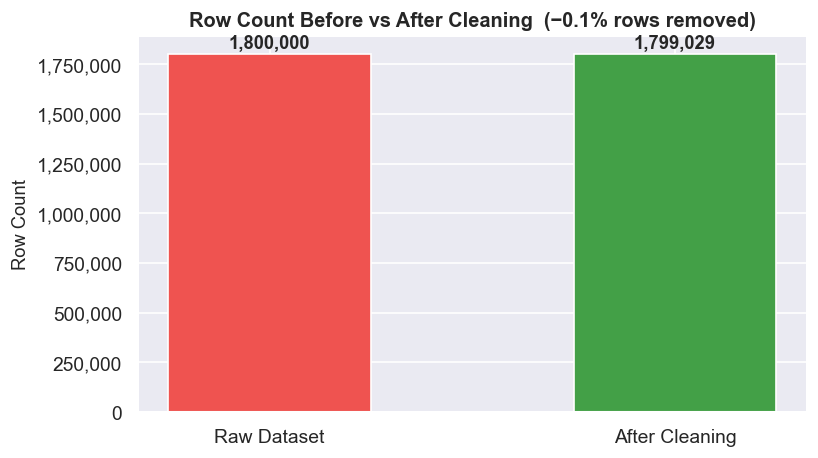

In [13]:
# ── Rows removed summary chart ─────────────────────────────────────────────
raw_count    = df_raw.shape[0]
clean_count  = df_clean.shape[0]
removed_pct  = (1 - clean_count / raw_count) * 100

fig, ax = plt.subplots(figsize=(7, 4), dpi=120)
bars = ax.bar(
    ['Raw Dataset', 'After Cleaning'],
    [raw_count, clean_count],
    color=['#EF5350', '#43A047'], width=0.5, edgecolor='white'
)
for bar, val in zip(bars, [raw_count, clean_count]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + raw_count*0.005,
            f'{val:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_ylabel('Row Count', fontsize=11)
ax.set_title(f'Row Count Before vs After Cleaning  (−{removed_pct:.1f}% rows removed)',
             fontsize=12, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
fig.savefig(f'{OUTPUT_DIR}/fig_03_cleaning_counts.png', dpi=120, bbox_inches='tight')
plt.show()

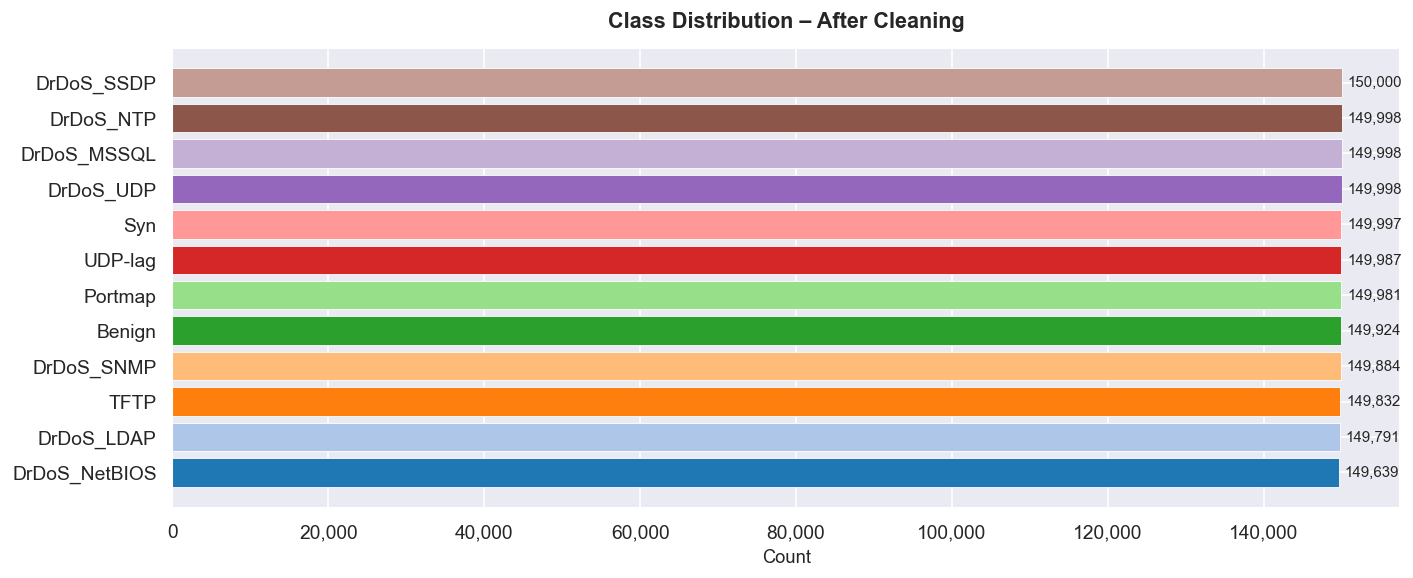

In [14]:
# ── Class distribution after cleaning ─────────────────────────────────────
fig = plot_label_distribution(df_clean[LABEL_COL], title='Class Distribution – After Cleaning')
fig.savefig(f'{OUTPUT_DIR}/fig_04_clean_class_dist.png', dpi=120, bbox_inches='tight')
plt.show()

## 4 · Label Encoding (One-Hot)

The `LabelBinarizer` is fitted here **only for display purposes**.
The authoritative fit happens in Notebook 02 on the training split.

In [15]:
X, y, feature_names = split_features_labels(df_clean, label_col=LABEL_COL)

# Fit a temporary encoder to show the mapping
temp_encoder = fit_label_encoder(y)
label_mapping = get_label_mapping(temp_encoder)

print('One-Hot Encoding Mapping (Label → Encoded Vector):')
print('-' * 55)
for cls, vec in label_mapping.items():
    print(f'  {cls:<30} → {vec}')
print(f'\nTotal classes: {len(label_mapping)}')

One-Hot Encoding Mapping (Label → Encoded Vector):
-------------------------------------------------------
  Benign                         → [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_LDAP                     → [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_MSSQL                    → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_NTP                      → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_NetBIOS                  → [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_SNMP                     → [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  DrDoS_SSDP                     → [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  DrDoS_UDP                      → [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
  Portmap                        → [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
  Syn                            → [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  TFTP                           → [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
  UDP-lag                        → [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

Total classes: 12


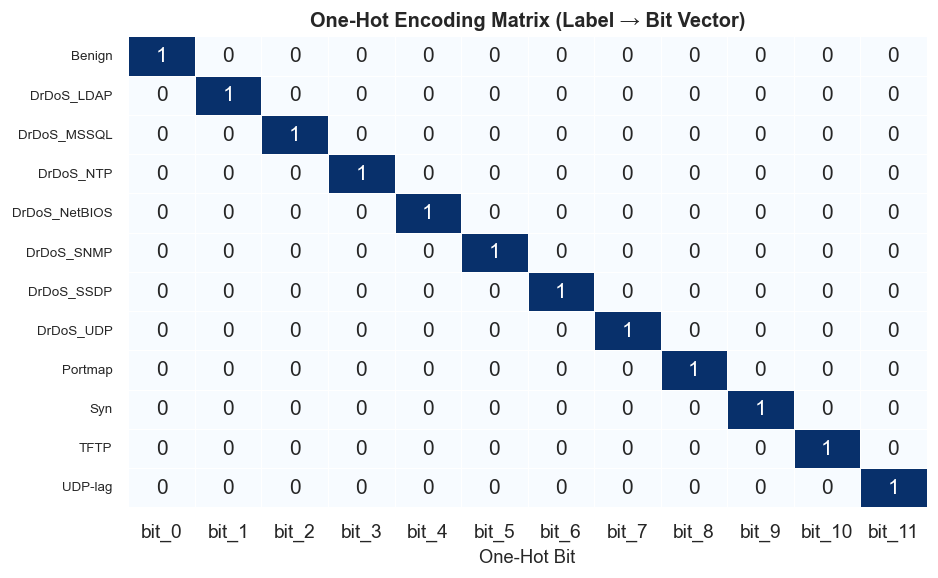

In [16]:
# Visualise the one-hot mapping as a table-style heatmap
import seaborn as sns

mapping_df = pd.DataFrame(
    {cls: vec for cls, vec in label_mapping.items()}
).T
mapping_df.columns = [f'bit_{i}' for i in range(mapping_df.shape[1])]

fig, ax = plt.subplots(figsize=(max(8, len(label_mapping)*0.5), 5), dpi=120)
sns.heatmap(
    mapping_df.astype(int),
    annot=True, fmt='d', cmap='Blues',
    linewidths=0.5, cbar=False, ax=ax
)
ax.set_xlabel('One-Hot Bit', fontsize=11)
ax.set_title('One-Hot Encoding Matrix (Label → Bit Vector)', fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
fig.savefig(f'{OUTPUT_DIR}/fig_05_onehot_matrix.png', dpi=120, bbox_inches='tight')
plt.show()

## 5 · Feature Summary

In [17]:
# Statistical summary of numeric features
desc = X.describe().T
display(desc.style.background_gradient(cmap='Blues', subset=['mean', 'std']))

,count,mean,std,min,25%,50%,75%,max
src_port,1799029.000000,25903.171130,25155.595446,0.000000,765.000000,21318.000000,51255.000000,65535.000000
dst_port,1799029.000000,30797.702228,20019.627756,0.000000,12916.000000,30738.000000,48506.000000,65535.000000
protocol,1799029.000000,14.650159,4.527349,0.000000,17.000000,17.000000,17.000000,17.000000
flow_duration,1799029.000000,2613231.195580,13946973.203178,1.000000,1.000000,2.000000,1546.000000,119999992.000000
flow_byts_s,1799029.000000,559357697.743915,816024243.881459,0.000000,1131.114095,70400000.000000,802000000.000000,2944000000.000000
flow_pkts_s,1799029.000000,1045286.843063,922715.955154,0.016714,7352.941176,1000000.000000,2000000.000000,4000000.000000
fwd_pkts_s,1799029.000000,1044548.572969,923350.640888,0.010579,5739.210285,1000000.000000,2000000.000000,4000000.000000
bwd_pkts_s,1799029.000000,738.270095,12314.121671,0.000000,0.000000,0.000000,0.000000,2000000.000000
tot_fwd_pkts,1799029.000000,8.404039,148.602813,1.000000,2.000000,2.000000,4.000000,91689.000000
tot_bwd_pkts,1799029.000000,0.705985,55.533223,0.000000,0.000000,0.000000,0.000000,21706.000000


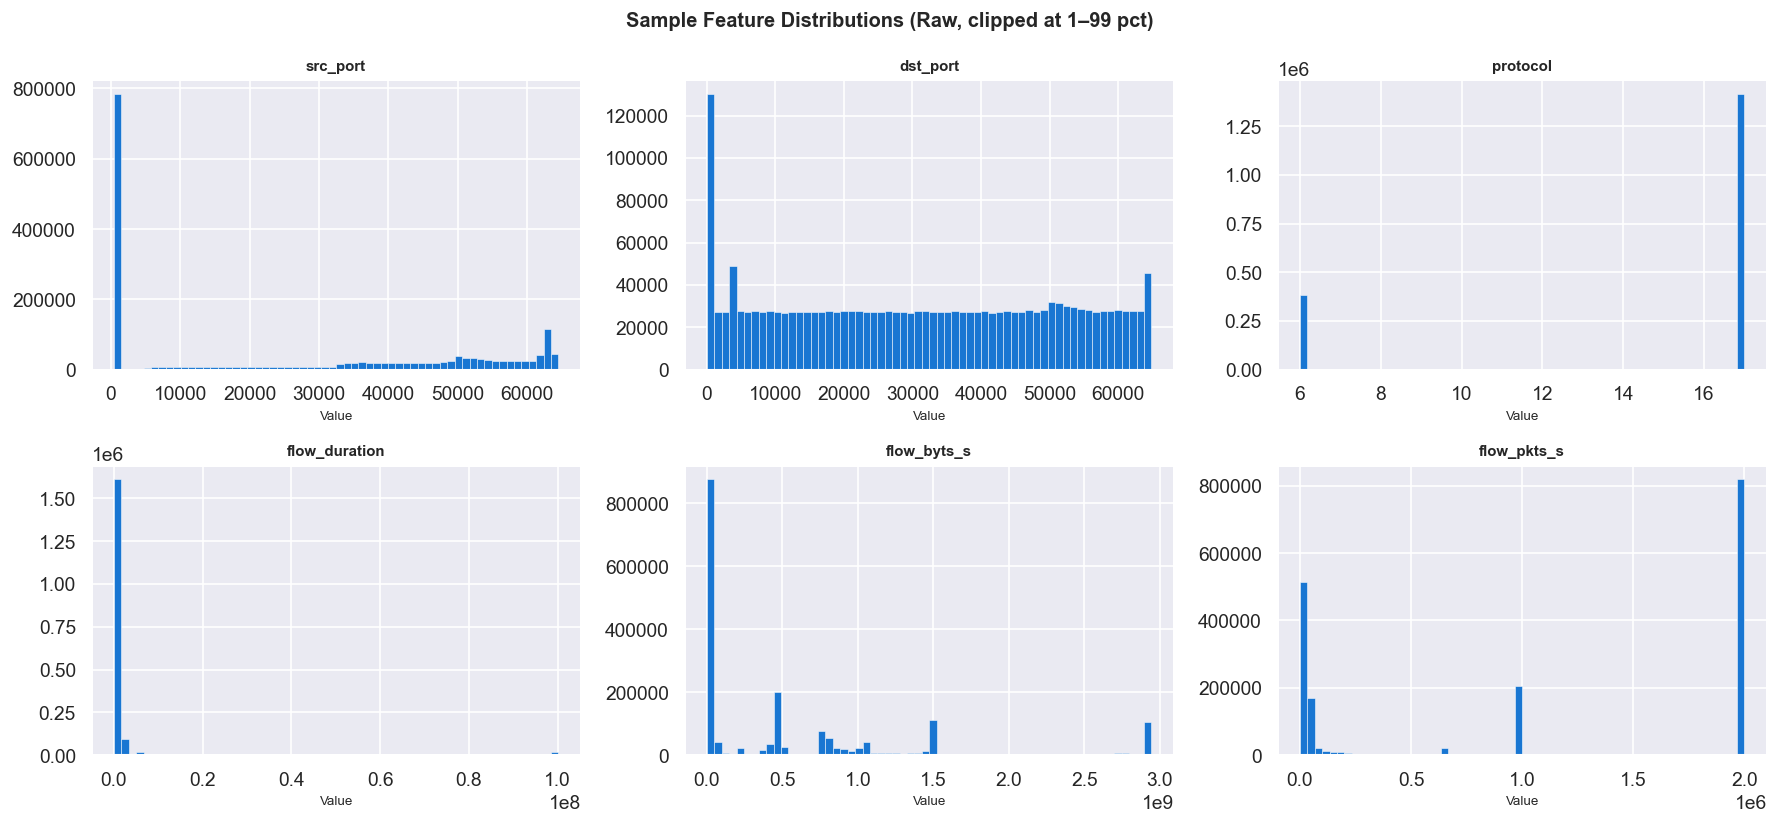

In [18]:
# Distribution of a few representative features
sample_features = X.columns[:6].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 7), dpi=120)
axes = axes.flatten()
for i, feat in enumerate(sample_features):
    axes[i].hist(X[feat].dropna().clip(lower=X[feat].quantile(0.01),
                                        upper=X[feat].quantile(0.99)),
                 bins=60, color='#1976D2', edgecolor='white', linewidth=0.3)
    axes[i].set_title(feat, fontsize=9, fontweight='bold')
    axes[i].set_xlabel('Value', fontsize=8)
fig.suptitle('Sample Feature Distributions (Raw, clipped at 1–99 pct)', fontsize=12, fontweight='bold')
plt.tight_layout()
fig.savefig(f'{OUTPUT_DIR}/fig_06_feature_dists.png', dpi=120, bbox_inches='tight')
plt.show()

## 6 · Persist Cleaned Dataset

In [ ]:
out_path = f'{OUTPUT_DIR}/cleaned_dataset.parquet'
df_clean.to_parquet(out_path, index=False)

print(f'✓ Cleaned dataset saved → {os.path.abspath(out_path)}')
print(f'  Shape : {df_clean.shape}')
print(f'  Classes: {sorted(df_clean[LABEL_COL].unique().tolist())}')

✓ Cleaned dataset saved → e:\Documents\Programming\Python\project\AI\Transformer DDoS Detector\data\processed\cleaned_dataset.parquet
  Shape : (1799029, 73)
  Classes: ['Benign', 'DrDoS_LDAP', 'DrDoS_MSSQL', 'DrDoS_NTP', 'DrDoS_NetBIOS', 'DrDoS_SNMP', 'DrDoS_SSDP', 'DrDoS_UDP', 'Portmap', 'Syn', 'TFTP', 'UDP-lag']


: 